In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Define the prior parameters
alpha_prior = 8  # Prior belief about the success rate (higher values = higher success rate)
beta_prior = 10  # Prior belief about the failure rate (higher values = lower success rate)

# Number of trials in the prior predictive
n_trials = 10

In [3]:
# Generate samples from the prior distribution of theta
theta_samples = stats.beta.rvs(alpha_prior, beta_prior, size=1000)

In [4]:
theta_samples.shape

(1000,)

In [5]:
# theta_samples

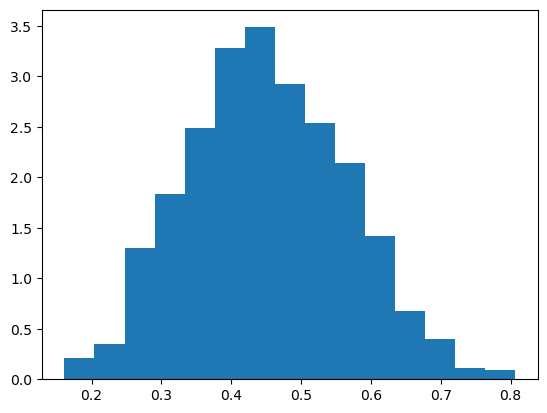

In [6]:
plt.hist(theta_samples, bins=15, density=True)
plt.show()

In [7]:
# Generate samples from the prior predictive distribution
prior_predictive_samples = np.random.binomial(n_trials, theta_samples)

In [8]:
prior_predictive_samples.shape

(1000,)

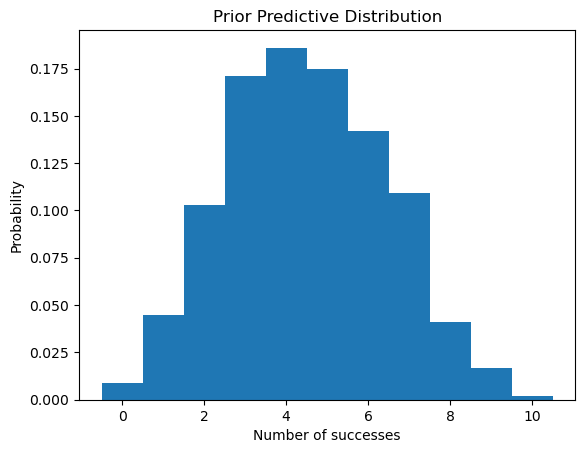

In [9]:
plt.hist(prior_predictive_samples, bins=np.arange(0, n_trials + 2) - 0.5, density=True)
plt.xlabel("Number of successes")
plt.ylabel("Probability")
plt.title("Prior Predictive Distribution")
plt.show()

Is the above correct? Let's also look at https://medium.com/@romoflow/the-beta-binomial-model-an-introduction-to-bayesian-statistics-154395875f93

Home wins example - downloaded data in results.csv

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, binom

In [11]:
n = 380

In [12]:
theta_checks = [0.40, 0.50, 0.60, 0.70]

In [13]:
y = np.arange(0,n+1)

In [14]:
y.shape

(381,)

In [15]:
current_theta = theta_checks[0]
p_y = binom.pmf(y, n, current_theta)

In [16]:
p_y.shape

(381,)

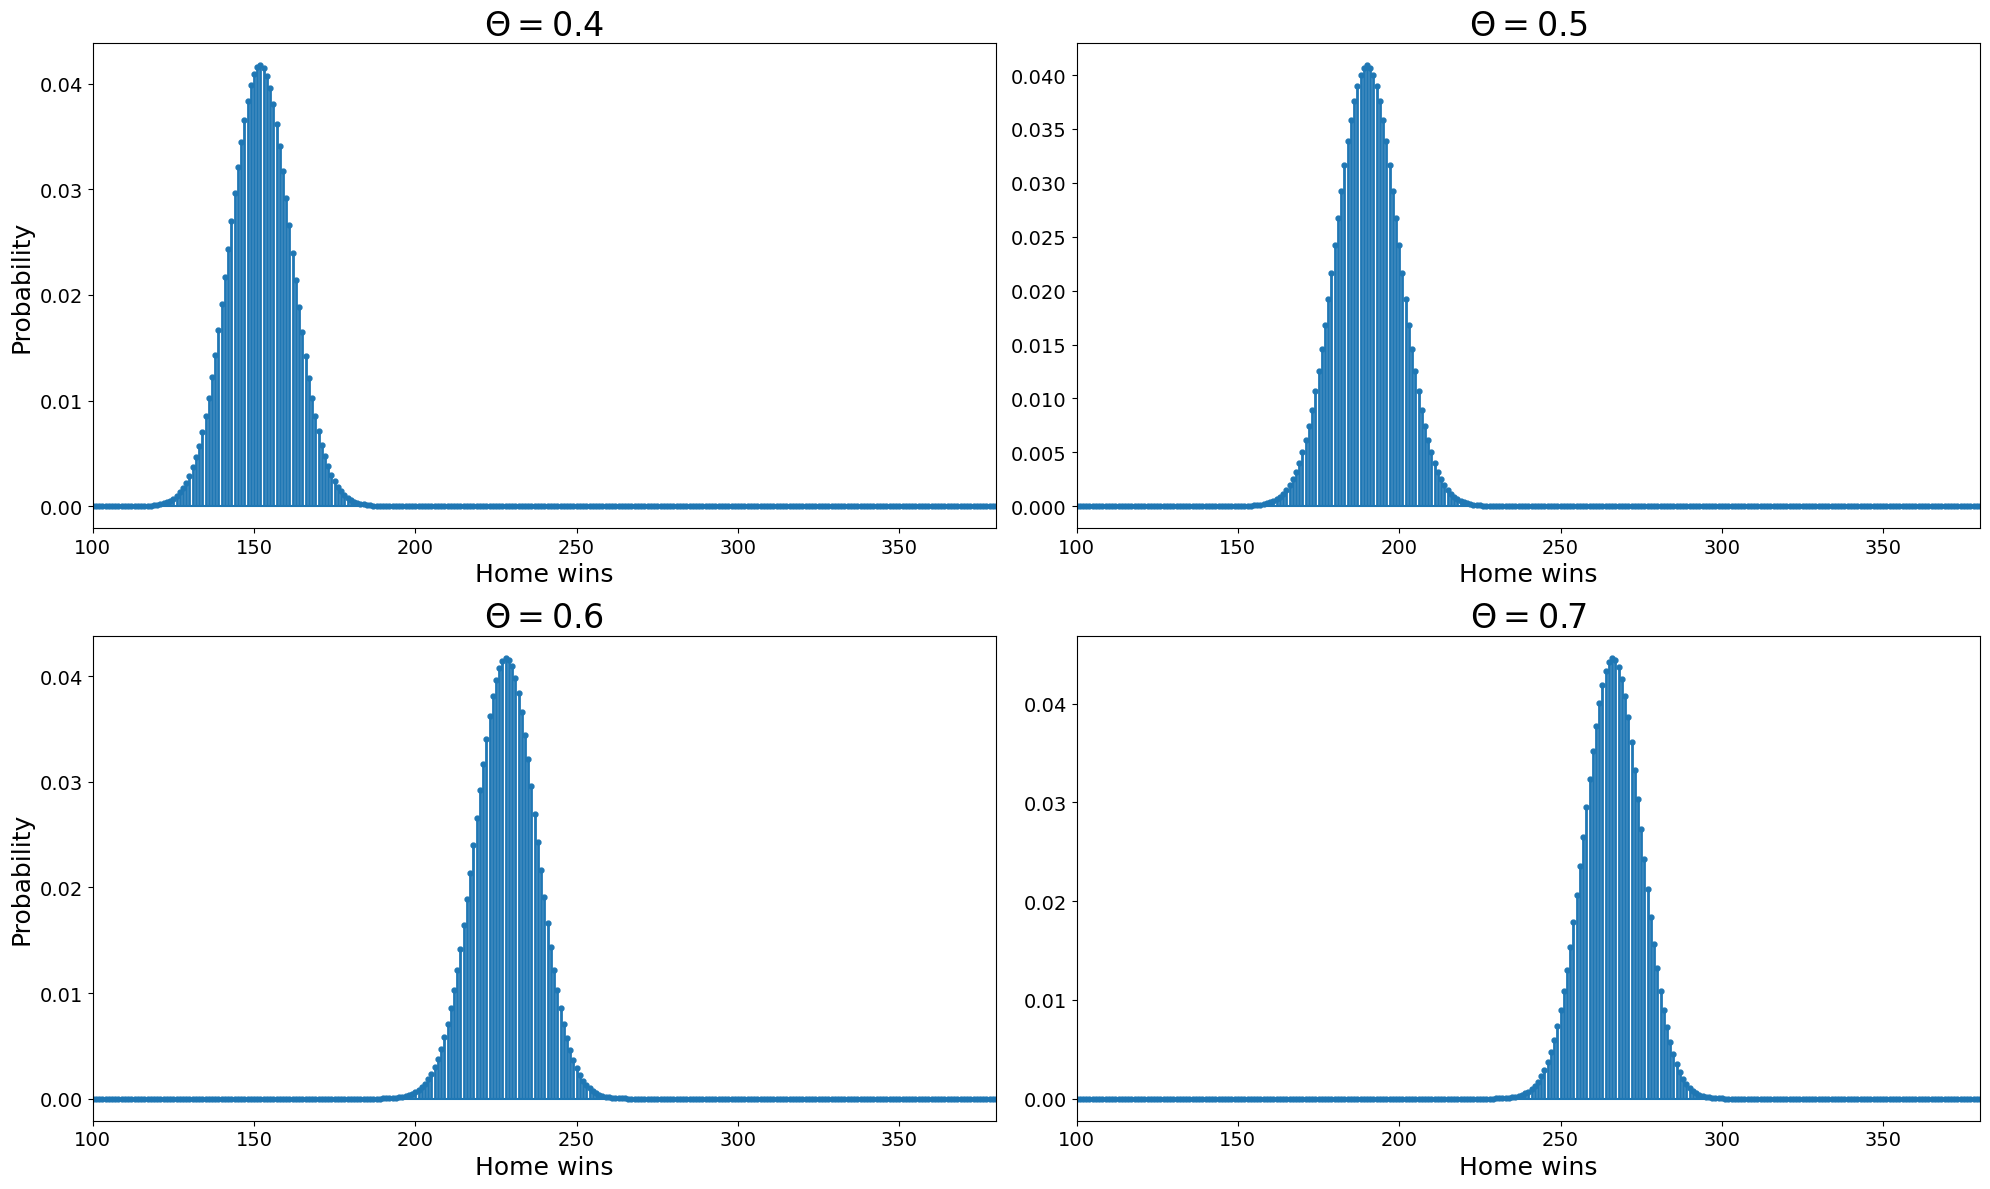

CPU times: user 1.05 s, sys: 618 ms, total: 1.67 s
Wall time: 17.6 s


In [17]:
%%time
# Visualisation of binomial distribution on Y - basically, how y looks like for different values of theta.
y = np.arange(0,n+1)
theta_checks = [0.40, 0.50, 0.60, 0.70]
fig, axes = plt.subplots(2,2,figsize = (20,12))
for i, ax in enumerate(axes.flat):
    current_theta = theta_checks[i]
    p_y = binom.pmf(y, n, current_theta)
    markerline, stemlines, baseline  = ax.stem(y, p_y, basefmt = '')
    ax.set_xlabel("Home wins", fontsize=18)
    if i in [0,2]:
        ax.set_ylabel("Probability", fontsize=18)
    ax.set_title("$\Theta = {}$".format(current_theta), fontsize=24)
    ax.set_xlim([100,380])
    #ax.vlines(observed_y, 0, 0.045, colors='k', linestyles='--', label='Observed value')
    #if i == 0:
        #ax.legend(fontsize=16)
    plt.setp(markerline, markersize = 3.5)
    plt.setp(stemlines, linewidth = 2)
    plt.setp(ax.get_xticklabels(), fontsize=14) 
    plt.setp(ax.get_yticklabels(), fontsize=14) 
plt.tight_layout()
plt.show()

now what about the prioir distribution?

In [18]:
data = pd.read_csv("results.csv", encoding = "ISO-8859-1")

In [19]:
data.head()

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,1993-94,1993-08-14T00:00:00Z,Arsenal,Coventry,0,3,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-94,1993-08-14T00:00:00Z,Aston Villa,QPR,4,1,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-94,1993-08-14T00:00:00Z,Chelsea,Blackburn,1,2,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-94,1993-08-14T00:00:00Z,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-94,1993-08-14T00:00:00Z,Man City,Leeds,1,1,D,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
data.shape

(11113, 23)

In [21]:
# Get data and stats for binomial likelihood
matches_2021 = data.query("Season == '2020-21'")
n = matches_2021.shape[0]
observed_y = (matches_2021.FTR == "H").sum()

In [22]:
observed_y

144

In [23]:
# Get historic stats for the prior
previous_home_rate = (data.query("Season in ['2015-16', '2016-17', '2017-18', '2018-19', '2019-20']").FTR == "H").mean()
previous_count = data.query("Season in ['2015-16', '2016-17','2017-18', '2018-19', '2019-20']").shape[0]

In [24]:
print("Historic home win rate: {:.2f}".format(previous_home_rate))
print("Historic number of matches: {}".format(previous_count))

Historic home win rate: 0.46
Historic number of matches: 1900


In [25]:
print("Data home win rate: {:.2f}".format(observed_y/n))
print("Number of matches in data: {}".format(n))

Data home win rate: 0.38
Number of matches in data: 380


In [26]:
# Let's first think about the beta prior. Based on the previous data, we know home run rate is 0.46 from 1900 matches.

a = previous_count*previous_home_rate
b = previous_count*(1-previous_home_rate)

In [27]:
a, b

(870.0, 1030.0)

In [28]:
# Functions for the model
def beta_binomial(previous_count, previous_home_rate, n, y):
    # Given a prior count and rate obtain beta prior parameters
    a = previous_count*previous_home_rate
    b = previous_count*(1 - previous_home_rate)
    assert a/(a+b) == previous_home_rate
    assert a+b == previous_count
    theta = np.linspace(0,1,1000)
    prior = beta.pdf(theta, a, b)
    likelihood = binom.pmf(y, n, theta)    
    posterior = beta.pdf(theta, a + y, b + (n-y))
    return prior, likelihood, posterior

In [29]:
def plot_model(prior, likelihood, posterior, l_scale = 1000, xlim = [0,1], filename = None):
    plt.figure(figsize = (10,6))
    theta = np.linspace(0,1,1000)
    plt.plot(theta, prior, label = "prior")
    # likelihood is scaled by l_scale factor
    plt.plot(theta, l_scale*likelihood, label = "likelihood")
    plt.plot(theta, posterior, label = "posterior")
    plt.xlabel("$\Theta$", fontsize = 12)
    plt.xlim(xlim)
    plt.legend(fontsize=12)
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

In [30]:
def plot_credible_interval(previous_count, previous_home_rate, n, y, prob = 0.95, xlim = [0,1],
                          filename = None):
    a = previous_count*previous_home_rate
    b = previous_count*(1 - previous_home_rate)
    theta = np.linspace(0,1,1000)
    posterior = beta.pdf(theta, a + y, b + (n-y))
    credible_interval = beta.interval(prob, a + y, b + (n-y))
    interval_domain = np.linspace(credible_interval[0], credible_interval[1], 100)
    posterior_interval = beta.pdf(interval_domain, a + y, b + (n-y)) 
    plt.figure(figsize = (10,6))
    plt.plot(theta, posterior)
    plt.fill_between(interval_domain, 0, posterior_interval, alpha = 0.7)
    plt.xlabel("$\Theta$")
    plt.xlim(xlim)
    if filename:
        plt.savefig(filename)
    else:
        plt.show()
    return credible_interval

In [31]:
def plot_cum_prob(previous_count, previous_home_rate, n, y, q, xlim = [0,1],
                          filename = None):
    a = previous_count*previous_home_rate
    b = previous_count*(1 - previous_home_rate)
    theta = np.linspace(0,1,1000)
    posterior = beta.pdf(theta, a + y, b + (n-y))
    query_domain = np.linspace(0, q, 1000)
    query_density = beta.pdf(query_domain, a + y, b + (n-y))
    plt.figure(figsize = (10,6))
    plt.plot(theta, posterior)
    plt.fill_between(query_domain, 0, query_density, alpha = 0.7)
    plt.xlabel("$\Theta$")
    plt.xlim(xlim)
    if filename:
        plt.savefig(filename)
    else:
        plt.show()
    return beta.cdf(q, a + y, b + (n-y))

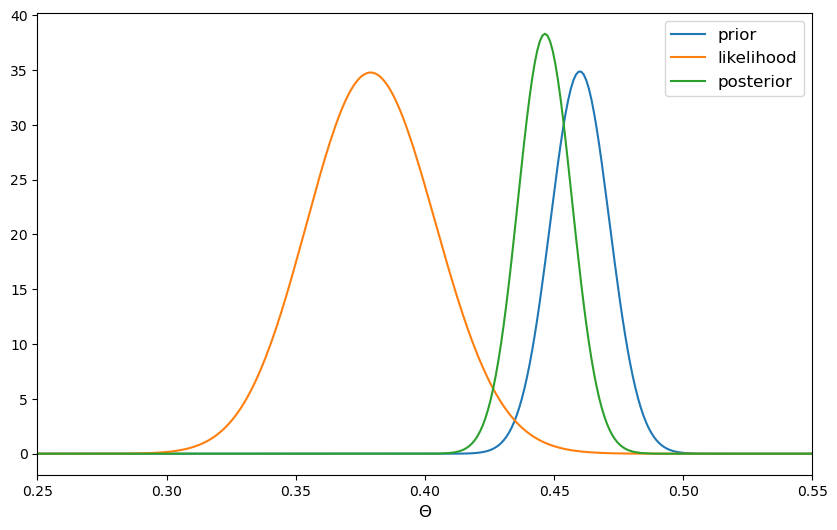

In [32]:
n = matches_2021.shape[0]
y = (matches_2021.FTR == "H").sum()
prior, likelihood, posterior = beta_binomial(previous_count, np.round(previous_home_rate, 2), n, y)
plot_model(prior, likelihood, posterior, l_scale = 825, xlim = [0.25,0.55])

In [33]:
n, y

(380, 144)

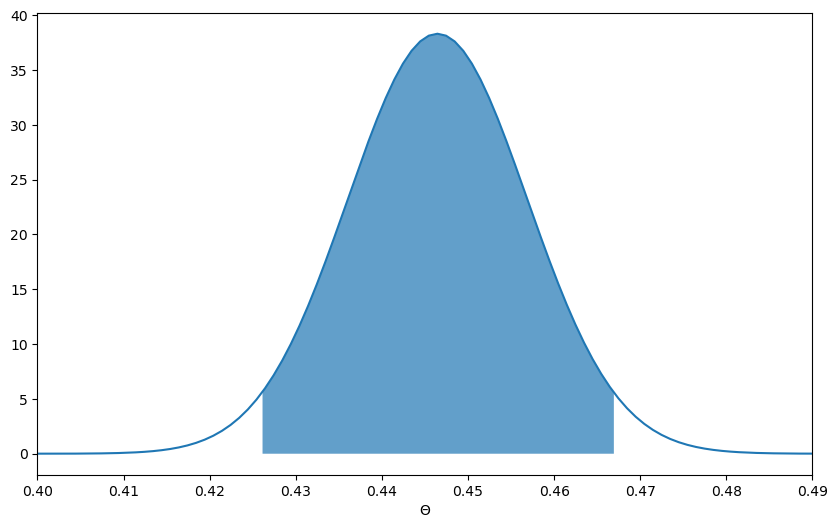

95% credible interval: (0.426, 0.467)


In [34]:
interval = plot_credible_interval(previous_count, np.round(previous_home_rate, 2), n, y, prob = 0.95, xlim = [0.4,0.49])
print("95% credible interval: ({:.3f}, {:.3f})".format(interval[0], interval[1]))

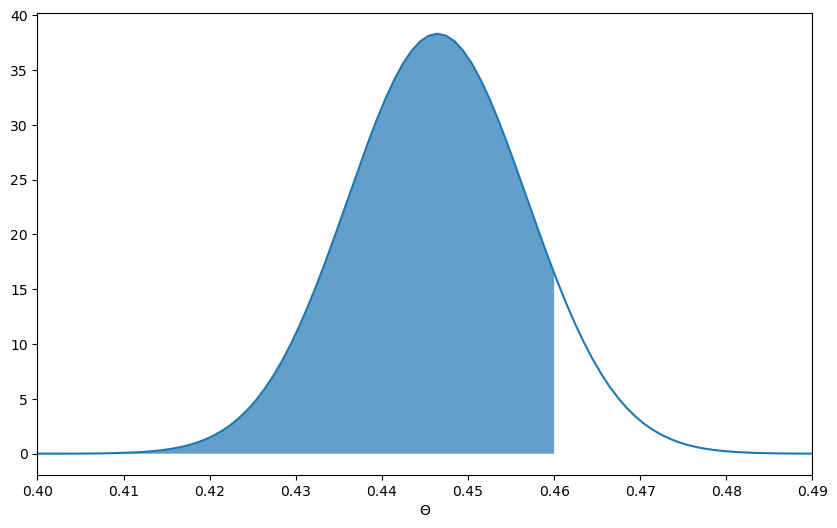

P(rate <= 0.46) = 0.90


In [35]:
prob = plot_cum_prob(previous_count, np.round(previous_home_rate, 2), n, y, 
                     np.round(previous_home_rate, 2), xlim = [0.4,0.49])
print("P(rate <= 0.46) = {:.2f}".format(prob))

In [ ]:
# Get prior and data weights
k = np.arange(1, 2500)
data_weight = n / (n+k)
prior_weight = k / (n+k)
plt.figure(figsize = (10,6))
plt.plot(k, data_weight, label = "data")
plt.plot(k, prior_weight, label = "prior")
plt.vlines(previous_count, 0,1, color = "k", linestyle = "--")
plt.text(previous_count - 50,0.1,'Historical matches',rotation=90, fontsize = 12)
plt.vlines(380, 0,1, color = "r", linestyle = "--")
plt.text(330,0.1,'Observed matches',color="r",rotation=90, fontsize = 12)
plt.legend(fontsize=12)
plt.xlabel("k", fontsize = 12)
plt.ylabel("Weight in posterior mean", fontsize = 12)
plt.show()